<a href="https://colab.research.google.com/github/ruchits-git/ruchits-git/blob/main/decisionTree_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Preprocessing

In [ ]:
import numpy as np
import pandas as pd
import math

# Dataset: Play Tennis

In [ ]:
data = pd.read_csv('PlayTennis.csv')
data

,outlook,temp,humidity,windy,play
0,sunny,hot,high,False,no
1,sunny,hot,high,True,no
2,overcast,hot,high,False,yes
3,rainy,mild,high,False,yes
4,rainy,cool,normal,False,yes
5,rainy,cool,normal,True,no
6,overcast,cool,normal,True,yes
7,sunny,mild,high,False,no
8,sunny,cool,normal,False,yes
9,rainy,mild,normal,False,yes


In [ ]:
data['outlook'] = data['outlook'].replace(['sunny', 'overcast', 'rainy'], [2,0,1])
data['temp'] = data['temp'].replace(['hot', 'mild', 'cool'], [1,2,0])
data['humidity'] = data['humidity'].replace(['high', 'normal'], [0,1])
data['windy'] = data['windy'].replace([False, True], [0,1])
data['play'] = data['play'].replace(['no', 'yes'], [0, 1])
data

,outlook,temp,humidity,windy,play
0,2,1,0,0,0
1,2,1,0,1,0
2,0,1,0,0,1
3,1,2,0,0,1
4,1,0,1,0,1
5,1,0,1,1,0
6,0,0,1,1,1
7,2,2,0,0,0
8,2,0,1,0,1
9,1,2,1,0,1


## Data Processing

In [ ]:
X = data.iloc[:,:-1].values
Y = data.iloc[:, -1].values.reshape(-1,1)

In [ ]:
feature_list = ['outlook', 'temp', 'humidity', 'windy']
target = 'play'

In [ ]:
data['outlook'].unique()

array([2, 0, 1], dtype=int64)

## Creating Tree and Node Class

In [ ]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        
        # for leaf node
        self.value = value

In [ ]:
class Tree:
    def __init__(self, min_samples_split=2, max_depth=3, mode="entropy"):
        # initialize the root of the tree 
        self.root = None
        self.mode = mode
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["info_gain"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        
        # compute leaf node
        z = list(Y)
        leaf_value = max(z, key=z.count)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        
        # dictionary to store the best split
        best_split = {}
        max_info_gain = -float("inf")
        
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_info_gain = self.information_gain(y, left_y, right_y)
                    # update the best split if needed
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain                    
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child):
        # function to compute information gain      
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if self.mode=="gini":
            gain = self.gini_index(parent) - (weight_l*self.gini_index(l_child) + weight_r*self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l*self.entropy(l_child) + weight_r*self.entropy(r_child))
        return gain
    
    def entropy(self, y):
        # Entropy calci
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        # gini index   
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
    
    def print_tree(self, tree=None, indent=" "):
        ''' function to print the tree '''
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(feature_list[tree.feature_index]), "<=", tree.threshold, "?", tree.info_gain)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
    
    def predict(self, X):    
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        # function to predict a single data point       
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

In [ ]:
classifier = Tree(min_samples_split=3,max_depth=3, mode="gini")
classifier.fit(X,Y)
classifier.print_tree()

X_outlook <= 0 ? 0.10204081632653056
 left:1
 right:X_humidity <= 0 ? 0.18000000000000016
  left:X_outlook <= 1 ? 0.11999999999999983
    left:1
    right:0
  right:X_windy <= 0 ? 0.11999999999999983
    left:1
    right:0


In [ ]:
from sklearn import tree 
classifier = tree.DecisionTreeClassifier(criterion="entropy").fit(X, Y)

[Text(133.92000000000002, 195.696, 'outlook <= 0.5\nentropy = 0.94\nsamples = 14\nvalue = [5, 9]'),
 Text(100.44000000000001, 152.208, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(167.40000000000003, 152.208, 'humidity <= 0.5\nentropy = 1.0\nsamples = 10\nvalue = [5, 5]'),
 Text(100.44000000000001, 108.72, 'outlook <= 1.5\nentropy = 0.722\nsamples = 5\nvalue = [4, 1]'),
 Text(66.96000000000001, 65.232, 'windy <= 0.5\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(33.480000000000004, 21.744, 'entropy = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(100.44000000000001, 21.744, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(133.92000000000002, 65.232, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0]'),
 Text(234.36, 108.72, 'windy <= 0.5\nentropy = 0.722\nsamples = 5\nvalue = [1, 4]'),
 Text(200.88000000000002, 65.232, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(267.84000000000003, 65.232, 'temp <= 1.0\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(234.36, 21.744, 

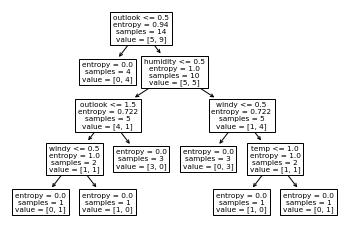

In [ ]:
tree.plot_tree(classifier, feature_names=feature_list)

## Testing

In [ ]:
y_pred = classifier.predict(X)
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(Y, y_pred)
print(cm)
accuracy_score(Y, y_pred)

[[5 0]
 [0 9]]


1.0

# Dataset: Iris

In [ ]:
data = pd.read_csv('Iris.csv')
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [ ]:
data['Species'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [ ]:
data['Species'] = data['Species'].replace(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], [0,1,2])
data

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,0
1,2,4.9,3.0,1.4,0.2,0
2,3,4.7,3.2,1.3,0.2,0
3,4,4.6,3.1,1.5,0.2,0
4,5,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,2
146,147,6.3,2.5,5.0,1.9,2
147,148,6.5,3.0,5.2,2.0,2
148,149,6.2,3.4,5.4,2.3,2


In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

In [ ]:
feature_list = ['Id',	'SepalLengthCm',	'SepalWidthCm',	'PetalLengthCm'	,'PetalWidthCm']
feature_list

['Id', 'SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

In [ ]:
#Importing train_test_split
from sklearn.model_selection import train_test_split
x_train  , x_test, y_train, y_test =train_test_split(X ,Y , test_size=0.3, stratify=Y)

In [ ]:
x_test.shape

(45, 5)

In [ ]:
x_train.shape

(105, 5)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(x_train, y_train)

DecisionTreeClassifier()

[Text(133.92000000000002, 181.2, 'Id <= 51.0\ngini = 0.667\nsamples = 105\nvalue = [35, 35, 35]'),
 Text(66.96000000000001, 108.72, 'gini = 0.0\nsamples = 35\nvalue = [35, 0, 0]'),
 Text(200.88000000000002, 108.72, 'Id <= 100.5\ngini = 0.5\nsamples = 70\nvalue = [0, 35, 35]'),
 Text(133.92000000000002, 36.23999999999998, 'gini = 0.0\nsamples = 35\nvalue = [0, 35, 0]'),
 Text(267.84000000000003, 36.23999999999998, 'gini = 0.0\nsamples = 35\nvalue = [0, 0, 35]')]

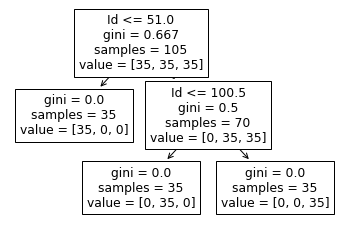

In [ ]:
tree.plot_tree(classifier, feature_names=feature_list)

In [ ]:
y_pred = classifier.predict(x_test)
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[15  0  0]
 [ 1 14  0]
 [ 0  0 15]]


0.9777777777777777

# Dataset: Diabetes

In [ ]:
data = pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
data['Outcome'].unique()

array([1, 0], dtype=int64)

In [ ]:
X = data.iloc[:, :-1].values
Y = data.iloc[:, -1].values

In [ ]:
feature_cols = np.array(data.columns)
feature_cols = feature_cols[:-1]
feature_cols

array(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
       'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype=object)

In [ ]:
#Importing train_test_split
from sklearn.model_selection import train_test_split
x_train  , x_test, y_train, y_test =train_test_split(X ,Y , test_size=0.2)

In [ ]:
x_test.shape

(154, 8)

In [ ]:
x_train.shape

(614, 8)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
diabetes = DecisionTreeClassifier()
diabetes.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = diabetes.predict(x_test)
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[89 24]
 [19 22]]


0.7207792207792207

[Text(169.34651162790698, 211.04470588235293, 'Glucose <= 142.5\ngini = 0.466\nsamples = 614\nvalue = [387, 227]'),
 Text(77.56848837209303, 198.25411764705882, 'BMI <= 26.95\ngini = 0.381\nsamples = 469\nvalue = [349, 120]'),
 Text(12.457674418604652, 185.4635294117647, 'Pregnancies <= 2.5\ngini = 0.089\nsamples = 128\nvalue = [122, 6]'),
 Text(9.343255813953489, 172.6729411764706, 'gini = 0.0\nsamples = 69\nvalue = [69, 0]'),
 Text(15.572093023255816, 172.6729411764706, 'Glucose <= 138.0\ngini = 0.183\nsamples = 59\nvalue = [53, 6]'),
 Text(12.457674418604652, 159.88235294117646, 'BMI <= 9.65\ngini = 0.158\nsamples = 58\nvalue = [53, 5]'),
 Text(6.228837209302326, 147.09176470588235, 'Pregnancies <= 7.5\ngini = 0.444\nsamples = 6\nvalue = [4, 2]'),
 Text(3.114418604651163, 134.30117647058825, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(9.343255813953489, 134.30117647058825, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(18.686511627906977, 147.09176470588235, 'DiabetesPedigr

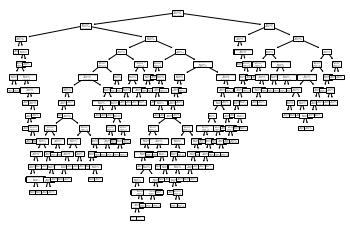

In [ ]:
#Graphviz
tree.plot_tree(diabetes, feature_names=feature_cols)

# Dataset: Car Prediction

In [ ]:
car = pd.read_csv('carprediction.csv')
car

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11909,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,46120
11910,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,56670
11911,Acura,ZDX,2012,premium unleaded (required),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50620
11912,Acura,ZDX,2013,premium unleaded (recommended),300.0,6.0,AUTOMATIC,all wheel drive,4.0,"Crossover,Hatchback,Luxury",Midsize,4dr Hatchback,23,16,204,50920


In [ ]:
car.isnull().sum().any()

True

In [ ]:
car.duplicated().sum()

715

In [ ]:
car.drop_duplicates(inplace=True)
car.duplicated().sum()

0

In [ ]:
car.dropna(inplace=True)
car.isnull().any().sum()

0

In [ ]:
columns = car.columns
columns = columns[:-1]
columns

Index(['Make', 'Model', 'Year', 'Engine Fuel Type', 'Engine HP',
       'Engine Cylinders', 'Transmission Type', 'Driven_Wheels',
       'Number of Doors', 'Market Category', 'Vehicle Size', 'Vehicle Style',
       'highway MPG', 'city mpg', 'Popularity'],
      dtype='object')

In [ ]:
car['city mpg'].unique()

array([ 19,  20,  18,  17,  16,  26,  23,  22,  21,  24,  15,  29,  28,
        25,  32,  31,  30,  14,  10,  27,  12,  13,   9,  11,   8,  50,
        49,  47,  35,  33,  40,  85,  42,  43,  36,  44,   7,  34, 137,
       129,  39,  41,  37,  53,  55,  51,  54,  58,  38, 128], dtype=int64)

In [ ]:
car.drop(['Make','Model','Engine Fuel Type', 'Vehicle Style'],axis=1, inplace=True)

In [ ]:
columns = car.columns
columns = columns[:-1]
columns

Index(['Year', 'Engine HP', 'Engine Cylinders', 'Transmission Type',
       'Driven_Wheels', 'Number of Doors', 'Market Category', 'Vehicle Size',
       'highway MPG', 'city mpg', 'Popularity'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for column in columns:
  car[column] = le.fit_transform(car[column])

car

,Year,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,highway MPG,city mpg,Popularity,MSRP
0,21,191,4,3,3,0,37,0,14,12,45,46135
1,21,167,4,3,3,0,66,0,16,12,45,40650
2,21,167,4,3,3,0,63,0,16,13,45,36350
3,21,116,4,3,3,0,66,0,16,11,45,29450
4,21,116,4,3,3,0,62,0,16,11,45,34500
...,...,...,...,...,...,...,...,...,...,...,...,...
11909,22,167,4,1,0,2,13,2,11,9,11,46120
11910,22,167,4,1,0,2,13,2,11,9,11,56670
11911,22,167,4,1,0,2,13,2,11,9,11,50620
11912,23,167,4,1,0,2,13,2,11,9,11,50920


In [ ]:
X = car.iloc[:, :-1].values
Y = car.iloc[:, -1].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5801, 11)
(5801,)
(1934, 11)
(1934,)


In [ ]:
# Training the Decision Tree Regression model on the whole dataset
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred = regressor.predict(X_test)
print(y_pred, y_test)
test = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test})
test

[ 34295. 219400.  18395. ...  24090.  44195.  20360.] [ 29295 210700  18495 ...  27795  49795  24340]


,y_pred,y_test
0,34295.00,29295
1,219400.00,210700
2,18395.00,18495
3,114900.00,122200
4,134436.00,103900
...,...,...
1929,32878.75,33130
1930,32645.00,42145
1931,24090.00,27795
1932,44195.00,49795


#### Accuracy score is only for classification problems. For regression problems you can use: R2 Score, MSE (Mean Squared Error), RMSE (Root Mean Squared Error).
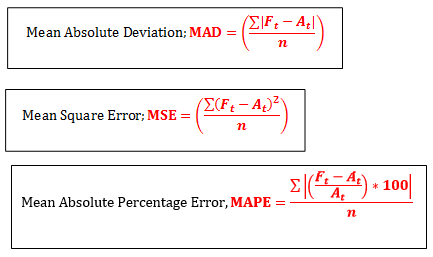

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
print(mean_absolute_percentage_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

0.10347217622070184
0.6814676724841388
